In [11]:
!pip install -q tensorflow==1.12

    100% |████████████████████████████████| 83.1MB 326kB/s 


In [12]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import urllib.request

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.50.99.26:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 7440834438946240187),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16109140092763111917),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6088657357957884958),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1190593449119574278),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10373999863711963863),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15029354667282645567),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6956336205529638657),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14469555840207958476),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 7127058954194

**Secondly**, prepare and import BERT modules.


In [13]:
import sys

!test -d bert_repo || git clone https://github.com/renjithamadeus/bert.git bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']
  
!jupyter nbconvert --to script bert_repo/data/create_train_test_datasets.ipynb

[NbConvertApp] WARNING | pattern u'bert_repo/data/create_train_test_datasets.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'n

**Thirdly**, prepare for training:

*  Specify task and download training data.
*  Specify BERT pretrained model
*  Specify GS bucket, create output directory for model checkpoints and eval results.


In [14]:
TASK = 'ER' #@param {type:"string"}
assert TASK in ('MRPC', 'CoLA', 'ER'), 'Only (MRPC, CoLA) are demonstrated here.'
# Download glue data.
# ! test -d download_glue_repo || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue_repo
# !python download_glue_repo/download_glue_data.py --data_dir='glue_data' --tasks=$TASK
BUCKET = 'training-data-27' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
TASK_DATA_DIR = 'gs://{}/er/data'.format(BUCKET)
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
LOCAL_TASK_DATA_DIR = 'data'
!test -d $LOCAL_TASK_DATA_DIR || mkdir $LOCAL_TASK_DATA_DIR
!gsutil cp -r -n $TASK_DATA_DIR .
!ls $LOCAL_TASK_DATA_DIR

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL
print('***** BERT pretrained directory: {} *****'.format(BERT_PRETRAINED_DIR))
!gsutil ls $BERT_PRETRAINED_DIR


OUTPUT_DIR = 'gs://{}/er/models/bert_seq_256/country'.format(BUCKET)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Task data directory: gs://training-data-27/er/data *****
Skipping existing item: file://./data/countries.json
Skipping existing item: file://./data/dev.tsv
Skipping existing item: file://./data/train.tsv
countries.json	dev.tsv  train.tsv
***** BERT pretrained directory: gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12 *****
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_config.json
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.index
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.meta
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/checkpoint
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt
***** Model output directory: gs://training-data-27/er/models/bert_seq_256/country *****


In [15]:
# Setup task specific model and TPU running config.

import modeling
import optimization
import run_classifier
import tokenization


# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 256
# Model configs
SAVE_CHECKPOINTS_STEPS = 5000
ITERATIONS_PER_LOOP = 1000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

processors = {
  "cola": run_classifier.ColaProcessor,
  "mnli": run_classifier.MnliProcessor,
  "mrpc": run_classifier.MrpcProcessor,
  "er": run_classifier.ExpenseReaderProcessor  
}
processor = processors[TASK.lower()]()
label_list = processor.get_labels(LOCAL_TASK_DATA_DIR)
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

train_examples = processor.get_train_examples(LOCAL_TASK_DATA_DIR)
num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=True,
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE)

INFO:tensorflow:Using config: {'_model_dir': 'gs://training-data-27/er/models/bert_seq_256/country', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.50.99.26:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f507ed3e8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.50.99.26:8470', '_evaluation_master': 'grpc://10.50.99.26:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, num_cores_

In [16]:
# Train the model.
print('MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('***** Started training at {} *****'.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('***** Finished training at {} *****'.format(datetime.datetime.now()))

MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...
INFO:tensorflow:Writing example 0 of 96303
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train-91826
INFO:tensorflow:tokens: [CLS] j * 1 ##va - y & \ # y ) t * , j ^ d ##1 ##war ^ r ^ * æ * 42 ##75 ##3 / hd # t # r # c # h * d bo ##m * y u * th # sum of k . d . _ on bank . . . j . _ _ being _ i _ fell ##ml ##i / j ##l ##wu * ja ul ##my - z • * * * * ' # fu ##k ##j i ##4 * * a / $ # & 23 ' u + is ##j * cash / che ##que no . . . . . & * an , cash ##ier ##re ##ce ##iving by % la ##j [SEP]
INFO:tensorflow:input_ids: 101 1046 1008 1015 3567 1011 1061 1004 1032 1001 1061 1007 1056 1008 1010 1046 1034 1040 2487 9028 1034 1054 1034 1008 1097 1008 4413 23352 2509 1013 10751 1001 1056 1001 1054 1001 1039 1001 1044 1008 1040 8945 2213 1008 1061 1057 1008 16215 1001 7680 1997 1047 1012 1040 1012 1035 2006 2924 1012 1012 1012 1046 1012 1035 1035 2108 1035 1045 1035 3062 19968 2072 1013 1046 2140 16050 1008 14855 1

In [17]:
# Eval the model.
eval_examples = processor.get_dev_examples(LOCAL_TASK_DATA_DIR)
eval_features = run_classifier.convert_examples_to_features(
    eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Writing example 0 of 24076
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: dev_matched-76002
INFO:tensorflow:tokens: [CLS] ra - auto ##ces ##ta ri ##je ##ka - zagreb d . dali ##ull ##n * 4 , lo ##oo ##o ja ##gie ##b ##gi ##b : 96 ##33 ##0 ##31 ##0 ##28 ##1 ##iz ##la ##z ##na post ##aja : nap ##lat ##no m ##je ##sto : 00 ##4 ##da ##tum : ul ##az ##na post ##aja : vr ##ij ##eme ul ##ask ##a : ra ##cu ##n bro ##j : , tel , : 08 ##00 01 ##11 ##kar ##lova ##cb ##lag ##aj ##nik : 47 ##14 ##43 ##27 / 10 / 2018 10 : 04 ##za ##gre ##b ##27 / 10 / 2018 09 : 36 ##20 ##18 ##10 ##27 ##10 ##30 ##41 ##00 ##46 ##64 ##65 ##kat ##ego ##ri ##ja 1 ##os ##nov ##ica ##pd ##v ( 25 % ) uk ##up ##no ##15 , 20 kn ##3 , 80 kn ##19 , 00 kn ##uk ##up ##na cl ##je ##na uk ##l ##ju ##ou ##je pd ##vna ##cl ##n pl ##ao ##an ##ja : bank ##ov ##na ka ##rt ##lc ##av ##rst ##a ka ##rti ##ce : master ##card ##bro ##j ka ##rti ##ce : 51 ##33 * * * * * * * * 89 ##9 ##l ##vr ##ij ##ed ##l do : bro ##j au

In [18]:
print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(eval_examples)))
print('  Batch size = {}'.format(EVAL_BATCH_SIZE))
# Eval will be slightly WRONG on the TPU because it will truncate
# the last batch.
eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
eval_input_fn = run_classifier.input_fn_builder(
    features=eval_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=True)
result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
with tf.gfile.GFile(output_eval_file, "w") as writer:
  print("***** Eval results *****")
  for key in sorted(result.keys()):
    print('  {} = {}'.format(key, str(result[key])))
    writer.write("%s = %s\n" % (key, str(result[key])))

***** Started evaluation at 2019-02-23 09:40:58.470338 *****
  Num examples = 24076
  Batch size = 8
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (1, 256)
INFO:tensorflow:  name = input_mask, shape = (1, 256)
INFO:tensorflow:  name = label_ids, shape = (1,)
INFO:tensorflow:  name = segment_ids, shape = (1, 256)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768

In [0]:
predict_input_fn = run_classifier.input_fn_builder(
    features=eval_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=True)
predictions = list(estimator.predict(input_fn=predict_input_fn))

In [0]:
import pandas as pd

labels_actual = [label_list[x.label_id] for x in eval_features]
labels_actual = pd.Series(labels_actual, name='Actual')
labels_predcted = [label_list[x['probabilities'].argmax()] for x in predictions]
labels_predcted = pd.Series(labels_predcted, name='Predicted')

# df_results = pd.DataFrame()
# df_results['actual_labels'] = actual_labels
# df_results['pred_labels'] = pred_labels

# df_class_freq =  df_results['actual_labels'].value_counts()
# to_remove = df_class_freq[df_class_freq <= 100].index
# _index = df_results[df_results['actual_labels'].isin(to_remove) | df_results['pred_labels'].isin(to_remove)].index
# df_results.drop(_index, inplace=True)


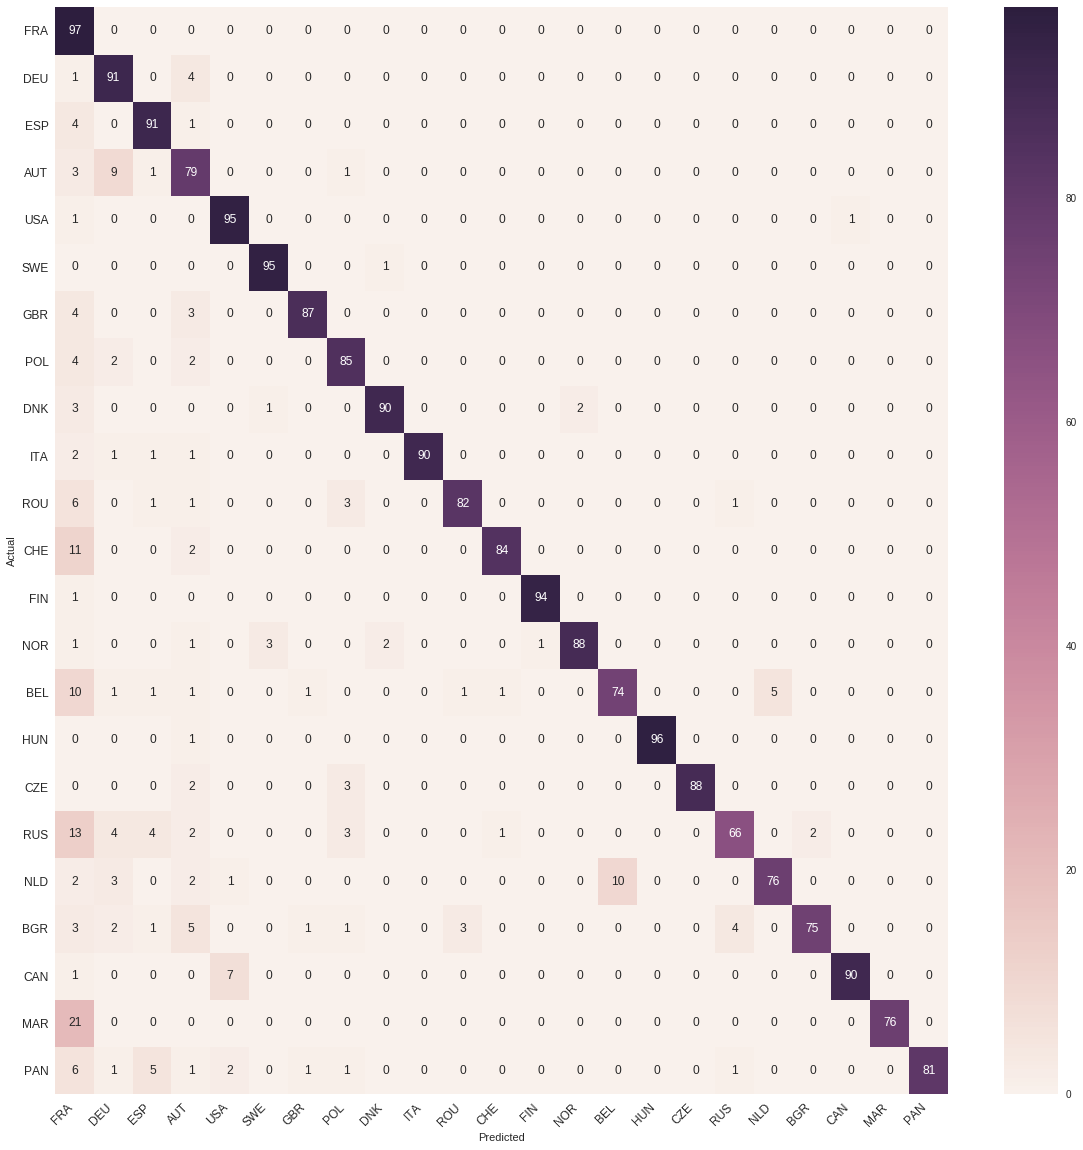

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,20))

countries_confusion_mat = pd.crosstab(labels_actual, labels_predcted, rownames=['Actual'], colnames=['Predicted'])

sum_by_col = countries_confusion_mat.sum(axis=1)
s = sum_by_col[sum_by_col > 100]
freq_countries = set(s.index)

cm = countries_confusion_mat.filter(items=freq_countries).filter(axis=0, items=freq_countries)
cm['sum'] = cm.sum(axis=1)
cm = cm.sort_values(by='sum', axis=0, ascending=False)
cm = cm[cm.index]
cm['sum'] = cm.sum(axis=1)
cm_norm = cm.div(cm['sum'], axis=0) * 100
del cm_norm['sum']

def print_confusion_matrix(confusion_matrix, figsize = (24,24), fontsize=12):
    heatmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print_confusion_matrix(cm_norm.astype(int), label_list)

In [22]:
!gsutil ls gs://cloud-tpu-checkpoints/bert/

gs://cloud-tpu-checkpoints/bert/cased_L-12_H-768_A-12/
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/
gs://cloud-tpu-checkpoints/bert/uncased_L-24_H-1024_A-16/
